In [ ]:
#pip install deepxde --upgrade;pip install tensorflow --upgrade

In [1]:
import os
os.environ['DDEBACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import deepxde as dde 
dde.config.disable_xla_jit()

from deepxde.backend import tf

seed = 1234
dde.config.set_random_seed(seed)

Using backend: tensorflow

2022-11-16 13:04:49.380401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 13:04:49.536871: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 13:04:50.204578: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-16 13:04:50.204639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plug

Enable just-in-time compilation with XLA.

Disable just-in-time compilation with XLA.



In [10]:
sigma0

1.1139285361810398

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Compiling model...
'compile' took 0.000602 s

Training model...



/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


Step      Train loss                                                      Test loss                                                       Test metric             
0         [1.36e-01, 4.08e-01, 2.36e+01, 6.22e+01, 1.00e+02, 1.50e+01]    [1.44e-01, 3.92e-01, 2.36e+01, 6.22e+01, 1.00e+02, 1.50e+01]    [2.90e+00, 2.82e+00]    
1000      [2.31e-02, 2.66e-02, 4.19e-03, 1.27e-03, 8.33e-04, 1.03e-03]    [2.19e-02, 2.64e-02, 4.19e-03, 1.27e-03, 8.33e-04, 1.03e-03]    [1.97e+00, 2.38e+00]    
2000      [1.52e-02, 1.77e-02, 4.45e-04, 5.86e-04, 4.00e-04, 2.46e-04]    [1.33e-02, 1.57e-02, 4.45e-04, 5.86e-04, 4.00e-04, 2.46e-04]    [1.74e+00, 2.19e+00]    
3000      [1.24e-02, 1.43e-02, 1.15e-04, 2.40e-04, 2.02e-04, 1.47e-04]    [1.05e-02, 1.30e-02, 1.15e-04, 2.40e-04, 2.02e-04, 1.47e-04]    [1.70e+00, 2.17e+00]    
4000      [1.10e-02, 1.20e-02, 7.37e-05, 1.33e-04, 1.34e-04, 8.22e-05]    [9.39e-03, 1.14e-02, 7.37e-05, 1.33e-04, 1.34e-04, 8.22e-05]    [1.74e+00, 2.18e+00]    
5000      [9.97e-03, 9

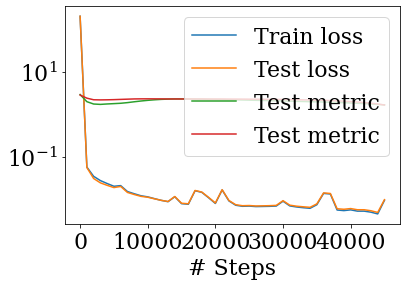

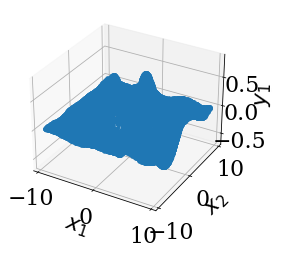

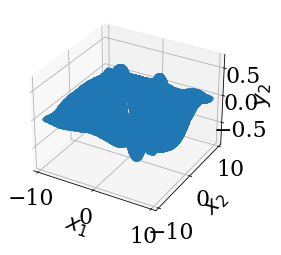

In [11]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import scipy
from scipy.special import jv, hankel1
from deepxde.backend import tf

# General parameters
weights = 100
epochs = 45000
learning_rate = 1e-3
num_dense_layers = 4
num_dense_nodes = 50
activation = "sin"

# Problem parameters
kappa = 1
wave_len = 2 * np.pi / kappa
length = 4 * np.pi
R = np.pi / 4
n_wave = 40
h_elem = wave_len / n_wave
nx = int(length / h_elem)

# PML constants
d_absorb = 2 * np.pi 
length_pml = length + d_absorb
sigma0 = -np.log(1e-20) / (4 * d_absorb ** 3 / 3)
box = np.array([[-length / 2, -length / 2], [length / 2, length / 2]])

# Computational domain

outer_pml = dde.geometry.Rectangle([- length_pml / 2, -length_pml / 2], [length_pml / 2, length_pml / 2])
inner = dde.geometry.Disk([0, 0], R)

geom = outer_pml - inner

# Exact solution
def sound_hard_circle_deepxde(kappa, a, points):
    fem_xx = points[:, 0:1]
    fem_xy = points[:, 1:2]
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)
    npts = np.size(fem_xx, 0)
    #n_terms = np.int(30 + (kappa * a) ** 1.01)
    n_terms = np.int(10 + (kappa * a) ** 1.01)

    u_sc = np.zeros((npts), dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        bessel_deriv = jv(n - 1, kappa * a) - n / (kappa * a) * jv(n, kappa * a)
        hankel_deriv = n / (kappa * a) * hankel1(n, kappa * a) - hankel1(n + 1, kappa * a)
        u_sc += (
            -((1j) ** (n))
            * (bessel_deriv / hankel_deriv)
            * hankel1(n, kappa * r)
            * np.exp(1j * n * theta)
        ).ravel()
    return u_sc


def PML(x):
    def sigma(x, a, b):
        """sigma(x) = 0 if a < x < b, else grows cubically from zero.
        """

        def _sigma(d):
            heav = tf.numpy_function(np.heaviside, [d,0], tf.float32)
            return sigma0 * d ** 2 * heav

        return tf.cast(_sigma(a - x) + _sigma(x - b), tf.complex64)

    def dsigma(x, a, b):
        def _sigma(d):
            heav = tf.numpy_function(np.heaviside, [d,0], tf.float32)
            return 2 * sigma0 * d * heav

        return tf.cast(-_sigma(a - x) + _sigma(x - b), tf.complex64)

    # Understand BOX
    sigma_x = sigma(x[:, :1], box[0][0], box[1][0])
    AB1 = 1 / (1 + 1j / kappa * sigma_x) ** 2
    A1, B1 = tf.math.real(AB1), tf.math.imag(AB1)

    dsigma_x = dsigma(x[:, :1], box[0][0], box[1][0])
    AB2 = -1j / kappa * dsigma_x * AB1 / (1 + 1j / kappa * sigma_x)
    A2, B2 = tf.math.real(AB2), tf.math.imag(AB2)

    sigma_y = sigma(x[:, 1:], box[0][1], box[1][1])
    AB3 = 1 / (1 + 1j / kappa * sigma_y) ** 2
    A3, B3 = tf.math.real(AB3), tf.math.imag(AB3)

    dsigma_y = dsigma(x[:, 1:], box[0][1], box[1][1])
    AB4 = -1j / kappa * dsigma_y * AB3 / (1 + 1j / kappa * sigma_y)
    A4, B4 = tf.math.real(AB4), tf.math.imag(AB4)
    return A1, B1, A2, B2, A3, B3, A4, B4

# Definition of the pde
def pde(x, y):

    A1, B1, A2, B2, A3, B3, A4, B4 = PML(x)
    
    y0, y1 = y[:, 0:1], y[:, 1:2]

    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y0_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    y0_x = dde.grad.jacobian(y, x, i=0, j=0)
    y0_y = dde.grad.jacobian(y, x, i=0, j=1)

    y1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    y1_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    y1_x = dde.grad.jacobian(y, x, i=1, j=0)
    y1_y = dde.grad.jacobian(y, x, i=1, j=1)
    
    loss_y0 = (
        (A1 * y0_xx + A2 * y0_x + A3 * y0_yy + A4 * y0_y) / kappa
        - (B1 * y1_xx  + B2 * y1_x + B3 * y1_yy + B4 * y1_y) / kappa
        + kappa * y0
    )
    loss_y1 = (
        (A1 * y1_xx  + A2 * y1_x + A3 * y1_yy + A4 * y1_y) /kappa
        + (B1 * y0_xx  + B2 * y0_x + B3 * y0_yy + B4 * y0_y) /kappa
        + kappa * y1
    )
    return -kappa * loss_y0, - kappa * loss_y1

#Exact solution and BCs
def sol(x):
    result = sound_hard_circle_deepxde(kappa, R, x).reshape((x.shape[0], 1))
    real = np.real(result)
    imag = np.imag(result)
    return np.hstack((real, imag))

def boundary(x, on_boundary):
    return on_boundary

def boundary_outer(x, on_boundary):
    return on_boundary and outer_pml.on_boundary(x)


def boundary_inner(x, on_boundary):
    return on_boundary and inner.on_boundary(x)


def func0_inner(x):
    normal = -inner.boundary_normal(x)
    g = 1j * kappa * np.exp(1j * kappa * x[:, 0:1]) * normal[:, 0:1]
    return np.real(-g)


def func1_inner(x):
    normal = -inner.boundary_normal(x)
    g = 1j * kappa * np.exp(1j * kappa * x[:, 0:1]) * normal[:, 0:1]
    return np.imag(-g)


def func0_outer(x, y):
    result = -kappa * y[:, 1:2]
    return result


def func1_outer(x, y):
    result = kappa * y[:, 0:1]
    return result


# ABCs
bc0_inner = dde.NeumannBC(geom, func0_inner, boundary_inner, component=0)
bc1_inner = dde.NeumannBC(geom, func1_inner, boundary_inner, component=1)

bc0_outer = dde.RobinBC(geom, func0_outer, boundary_outer, component=0)
bc1_outer = dde.RobinBC(geom, func1_outer, boundary_outer, component=1)

bcs = [bc0_inner, bc1_inner, bc0_outer, bc1_outer]

loss_weights = [1, 1, weights, weights, weights, weights]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx**2,
    num_boundary=8 * nx,
    num_test=5 * nx**2,
    solution=sol,
)
net = dde.maps.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)
model = dde.Model(data, net)

def l2_error_0(y_true, y_pred):
    test = data.test_x
    identity_int = (np.max(np.abs(test), axis=1) <= length / 2) 
    y_true = y_true[identity_int, 0]
    y_pred = y_pred[identity_int, 0]
    pred = y_true - y_pred
    return np.linalg.norm(pred) /np.linalg.norm(y_true) 

def l2_error_1(y_true, y_pred):
    test = data.test_x
    identity_int = (np.max(np.abs(test), axis=1) <= length / 2) 
    y_true = y_true[identity_int, 1]
    y_pred = y_pred[identity_int, 1]
    pred = y_true - y_pred
    return np.linalg.norm(pred) /np.linalg.norm(y_true) 

model.compile(
    "adam", lr=learning_rate, loss_weights=loss_weights, metrics=[l2_error_0, l2_error_1]
)
losshistory, train_state = model.train(epochs=epochs)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Relative error =  1.566588333558388


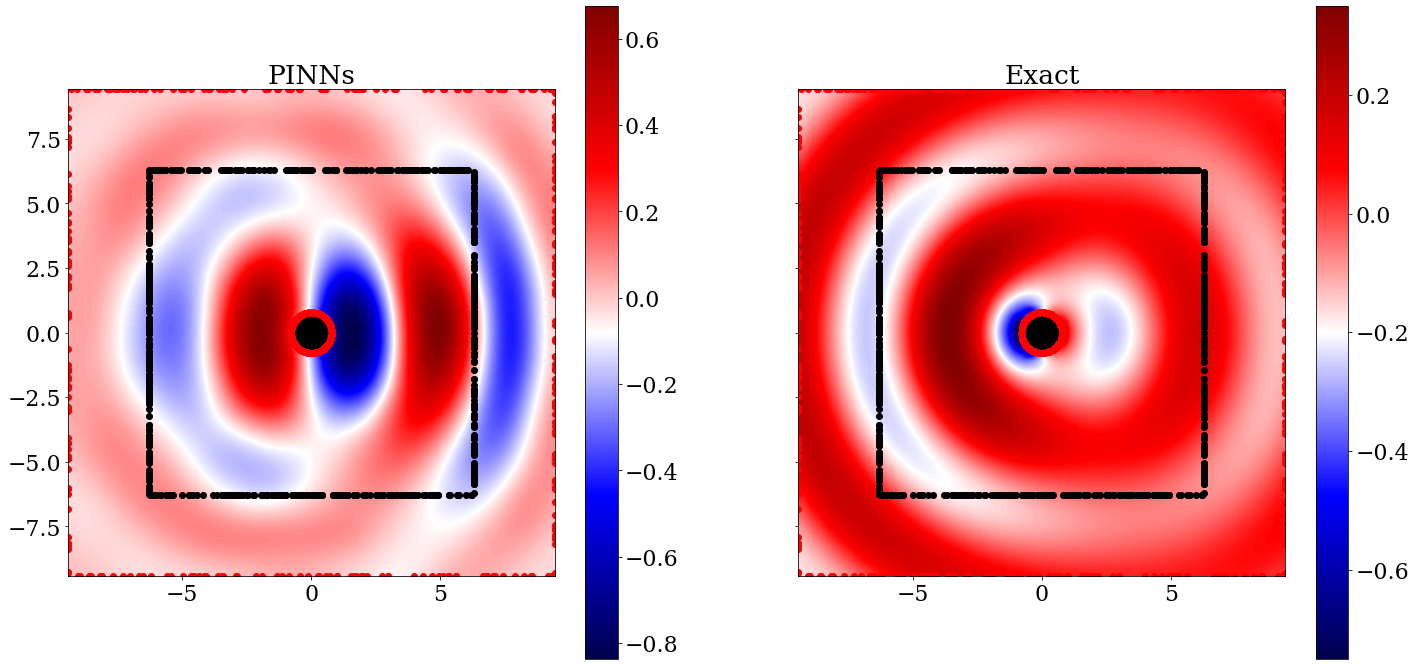

In [12]:
from matplotlib import pyplot as plt
'''            Evaluate field over a specified grid of points              '''
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(length/wave_len * 30))
Ny = Nx

# Grid points
xmin, xmax, ymin, ymax = [-length_pml/2, length_pml/2., -length_pml/2, length_pml/2]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

#in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
#in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
#points[0, in_circ] = -radius - wave_len / 10
#points[1, in_circ] = radius + wave_len / 10
#points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations

u_sca = model.predict(points[:2, :].T)
u_sca = u_sca[:, 0] + 1j* u_sca[:, 1]
#u_sca = u_sca[0] + 1j* u_sca[1]

u_exact = sol(points_2d.T)
u_exact = u_exact[:, 0] + 1j * u_exact[:, 1]

ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) <= R

u_exact[ide] = 0
u_sca[ide] = 0

u_exact = u_exact.reshape((Nx, Ny))
u_sca = u_sca.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run




diff = u_exact-u_sca
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.imag(u_sca)).T,
           extent=[-length_pml/2, length_pml/2., -length_pml/2, length_pml/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')

circle = plt.Circle((0., 0.), R, color='black', fill=True)
ax1.add_patch(circle)
#ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.imag(u_exact)).T,
           extent=[-length_pml/2, length_pml/2., -length_pml/2, length_pml/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')

circle = plt.Circle((0., 0.), R, color='black', fill=True)
ax2.add_patch(circle)

outer = dde.geometry.Rectangle([-length  / 2, -length / 2], [length / 2, length / 2])

x = outer.random_boundary_points(8 * nx)
ax1.scatter(x[:,0], x[:,1], color = 'k')
ax2.scatter(x[:,0], x[:,1], color = 'k')

x = geom.random_boundary_points(8 * nx)
ax1.scatter(x[:,0], x[:,1], color = 'r')
ax2.scatter(x[:,0], x[:,1], color = 'r')

x = geom.random_points(nx * nx)
#ax1.scatter(x[:,0], x[:,1], color = 'r')
#ax2.scatter(x[:,0], x[:,1], color = 'r')

#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)

plt.savefig('img.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Relative error =  1.72124517352


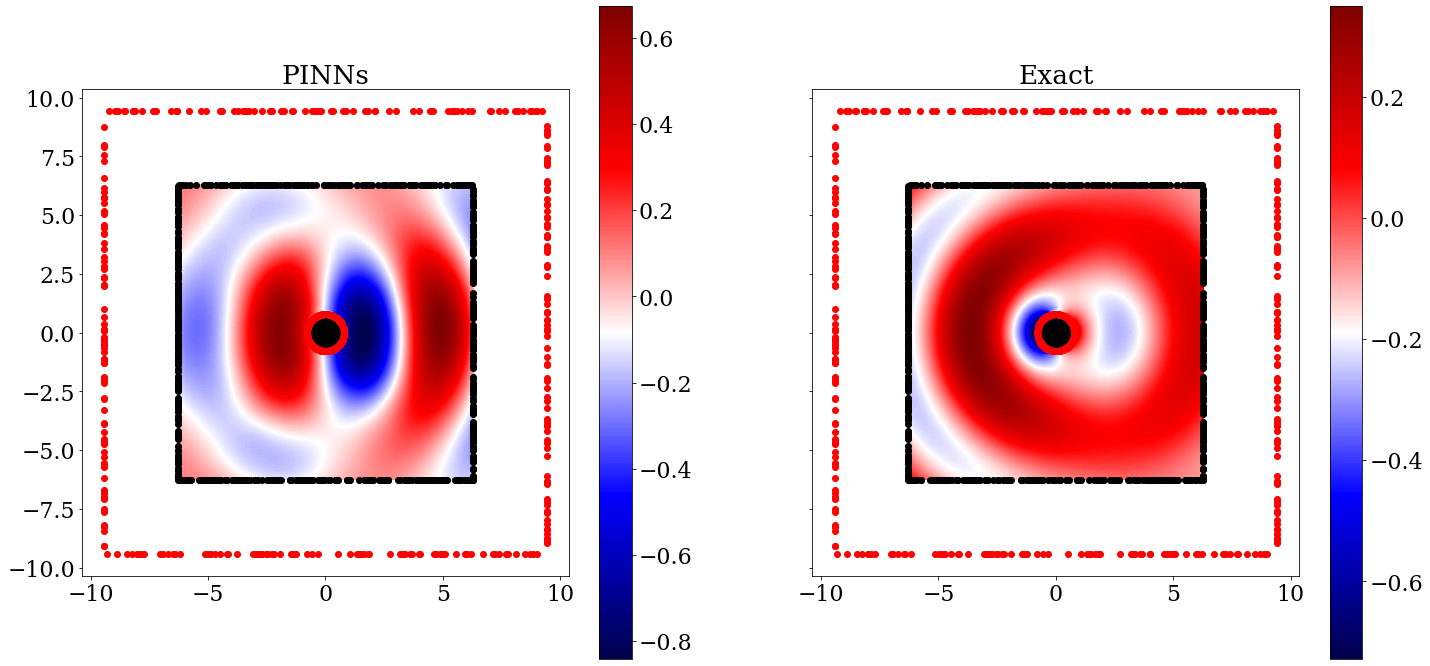

In [13]:
from matplotlib import pyplot as plt
'''            Evaluate field over a specified grid of points              '''
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(length/wave_len * 30))
Ny = Nx

# Grid points
xmin, xmax, ymin, ymax = [-length/2, length/2., -length/2, length/2]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

#in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
#in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
#points[0, in_circ] = -radius - wave_len / 10
#points[1, in_circ] = radius + wave_len / 10
#points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations

u_sca = model.predict(points[:2, :].T)
u_sca = u_sca[:, 0] + 1j* u_sca[:, 1]
#u_sca = u_sca[0] + 1j* u_sca[1]

u_exact = sol(points_2d.T)
u_exact = u_exact[:, 0] + 1j * u_exact[:, 1]

ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) <= R

u_exact[ide] = 0
u_sca[ide] = 0

u_exact = u_exact.reshape((Nx, Ny))
u_sca = u_sca.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run


vmin_real = np.min([np.real(u_exact), np.real(u_sca)])
vmin_imag = np.min([np.imag(u_exact), np.imag(u_sca)])

vmax_real = np.max([np.real(u_exact), np.real(u_sca)])
vmax_imag = np.max([np.imag(u_exact), np.imag(u_sca)])



diff = u_exact-u_sca
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.imag(u_sca)).T,
           extent=[-length/2, length/2., -length/2, length/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN', vmin=vmin_imag, vmax=vmax_imag)

circle = plt.Circle((0., 0.), R, color='black', fill=True)
ax1.add_patch(circle)
#ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.imag(u_exact)).T,
           extent=[-length/2, length/2., -length/2, length/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')

circle = plt.Circle((0., 0.), R, color='black', fill=True)
ax2.add_patch(circle)

outer = dde.geometry.Rectangle([-length  / 2, -length / 2], [length / 2, length / 2])

x = outer.random_boundary_points(8 * nx)
ax1.scatter(x[:,0], x[:,1], color = 'k')
ax2.scatter(x[:,0], x[:,1], color = 'k')

x = geom.random_boundary_points(8 * nx)
ax1.scatter(x[:,0], x[:,1], color = 'r')
ax2.scatter(x[:,0], x[:,1], color = 'r')

x = geom.random_points(nx * nx)
#ax1.scatter(x[:,0], x[:,1], color = 'r')
#ax2.scatter(x[:,0], x[:,1], color = 'r')

#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)

plt.savefig('img.png')

In [14]:
test = data.test_x
identity_out = (np.max(np.abs(test), axis=1) > length / 2) 
identity_int = (np.max(np.abs(test), axis=1) <= length / 2) 


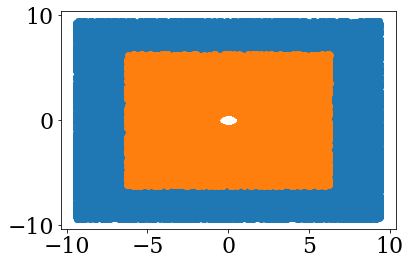

In [15]:

test_out = test[identity_out, :]
test_int = test[identity_int, :]

#plt.scatter(data.test_x[:, 0], data.test_x[:, 1])
plt.scatter(test_out[:, 0], test_out[:, 1])
plt.scatter(test_int[:, 0], test_int[:, 1])




In [16]:
data.test_x[:, 1].max()

9.424778

In [17]:
length/2

6.283185307179586